<a href="https://colab.research.google.com/github/tcardwell/Predicting-Distracted-Drivers/blob/master/1_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Distracted Drivers
## Tracy Cardwell

### Data Preprocessing


## Introduction  

According to the CDC, every day in America about 9 people are killed and more than 1000 are injured in crashes that involve a distracted driver.  

Distractions include:  
* visual: taking your eyes off the road;  
* manual: taking your hands off the steering wheel; and  
* cognitive: taking your mind off driving.   
    
This project aims to identify distractions from dashboard camera images taken during driving. The distractions captured in the images are:   
* texting with right hand,  
* holding phone in right hand,  
* texting with left hand,   
* holding phone in left hand,   
* operating the radio,   
* drinking,  
* reaching behind,  
* fixing hair or applying makeup, and  
* talking to a passenger.  
There are also images of safe driving. 
    
Note: these images were created by State Farm Insurance company in a controlled environment - a truck dragging a car around on the streets - so these "drivers" weren't really driving.  

The goal of this exercise is to determine whether dashboard cameras can automatically detect distracted drivers and perhaps provide a method to reduce distracted driver accidents, injuries and deaths.  

 
    


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
# Set plot fontsize defaults
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [0]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load environment variables. 
project_path = "/content/drive/My Drive/Capstone 2/"
raw_data_path = "data/raw"
proc_data_path = "data/processed"

In [0]:
filename = "state-farm-distracted-driver-detection.zip"
zip_path = os.path.normpath(os.path.join(project_path, filename))
print(zip_path)
!cp "{zip_path}" .
!unzip -q {filename}
!rm {filename}

/content/drive/My Drive/Capstone 2/state-farm-distracted-driver-detection.zip


In [0]:
# Get environment variables and set path variables. 

raw_train_path = "imgs/train"
raw_test_path = "imgs/test"

proc_train_path = "proc/imgs/train"
proc_test_path = "proc/imgs/test"
proc_valid_path = "proc/imgs/valid"

driver_images_list_path = "driver_imgs_list.csv"


In [0]:
driver_images_list = pd.read_csv(driver_images_list_path)
driver_images_list.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [0]:
driver_images_list.tail()

subject classname            img
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

In [0]:
# Determine number of classes.
NUM_CLASSES = driver_images_list.classname.nunique()
NUM_CLASSES

10

In [0]:
# Get class labels.
CLASSES = list(driver_images_list.classname.unique())
CLASSES

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [0]:
# How many subjects (drivers) in the images?
NUM_SUBJECTS = driver_images_list.subject.nunique()
NUM_SUBJECTS

26

In [0]:
# Find total number of training images.
NUM_TRAIN_IMGS = 0
for root, dirs, files in os.walk(raw_train_path):
    NUM_TRAIN_IMGS += len(files)
NUM_TRAIN_IMGS

22424

### Project Outline

1. Determine size of images, consistency of image sizes
1. Load images
2. Bar plot of image sizes (moot as all same)
3. Plot pixel intensities of images
4. Statistical analysis to determine best image size to model (moot as all same)

5. Split training into test/train/validate w labels 
5. Crop images

5. Normalize images
6. Resize images

7. Simple model with no augmentation as baseline.
8. More complex model no augmentation
9. Model with augmentation
10. Transfer learning


In [0]:
def check_image_attrs(path):
    """
    Check width, height and mode of images in path. 
    
    Return number of values found for each and the DataFrame df_img_attr. 
    """
   
    # Walk directory tree, check all images attributes. If can't open file with Image.open, skip as not an image. 
    img_attr = {}

    for root, dirs, files in os.walk(path):
        for name in files:
            img_filename = os.path.normpath(os.path.join(root, name))
            try:
                with Image.open(img_filename) as img:
                    width, height = img.size
                    mode = img.mode
                    img_attr[img_filename] = {'width': width, 'height': height, 'mode': mode}  
            except:
                pass
    
    # Convert dictionary to dataframe for easier processing. Count number of unique values for each of the 
    #    three attributes tracked. 
    df_img_attr = pd.DataFrame.from_dict(img_attr, orient='index')
    num_widths = len(df_img_attr['width'].value_counts())
    num_heights = len(df_img_attr['height'].value_counts())
    num_modes = len(df_img_attr['mode'].value_counts())
    
    return(num_widths, num_heights, num_modes, df_img_attr)

num_widths, num_heights, num_modes, df_img_attr = check_image_attrs(raw_train_path)
num_widths, num_heights, num_modes

(1, 1, 1)

In [0]:
width = df_img_attr['width'][0]
height = df_img_attr['height'][0]
mode = df_img_attr['mode'][0]
width, height, mode

(640, 480, 'RGB')

#### All the training images have the same width, height and mode. They are all 640x480 RGB encoded images. 

In [0]:
def rgb_hist_img(img_filename):
    """
    Plot pixel intensity distribution of R, G, B channels of a color image. 
    """
    with Image.open(img_filename) as img:
        histogram = img.histogram()

    # Get red counts
    R = histogram[0:256]
    # Get green counts
    G = histogram[256:512]
    # Get blue counts
    B = histogram[512:768]
    
    max_ticks = max(histogram)
    
    plt.figure(figsize=(16,4))

    # Red pixels
    plt.subplot(1,3,1)
    i = np.arange(0,256)
    plt.bar(i, R, color='r', edgecolor='r', alpha=0.3)
    plt.ylim(top=max_ticks)
    plt.title('Red pixels', fontsize=BIGGER_SIZE)      
    plt.xlabel('Intensity')
    plt.ylabel('Number of Pixels')
 
    # Green pixels
    plt.subplot(1,3,2)
    plt.bar(i, G, color='g', edgecolor='g', alpha=0.3)
    plt.ylim(top=max_ticks)
    plt.title('Green pixels', fontsize=BIGGER_SIZE)
    plt.xlabel('Intensity')
    plt.ylabel('Number of Pixels')
 
 
    # Blue pixels
    plt.subplot(1,3,3)
    plt.bar(i, B, color='b', edgecolor='b', alpha=0.3)
    plt.ylim(top=max_ticks)
    plt.title('Blue pixels', fontsize=BIGGER_SIZE)
    plt.xlabel('Intensity')
    plt.ylabel('Number of Pixels')
 
    plt.tight_layout()
    plt.show()
    
    return()


Image File:  img_33222.jpg  from:  imgs/train/c2


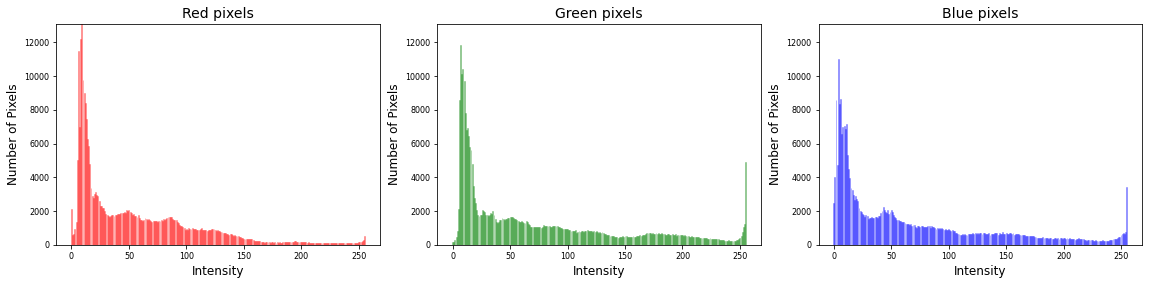

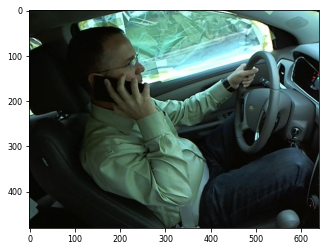

Image File:  img_46098.jpg  from:  imgs/train/c1


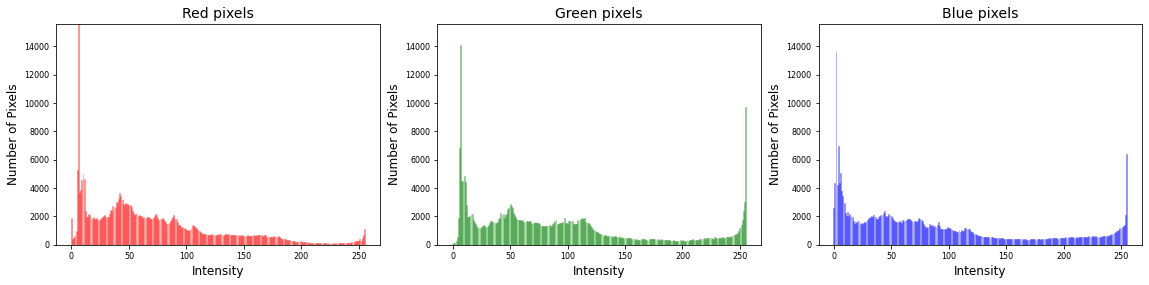

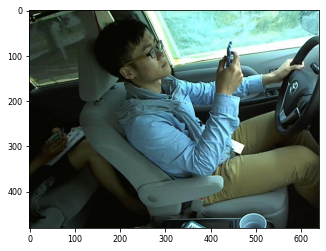

Image File:  img_66016.jpg  from:  imgs/train/c7


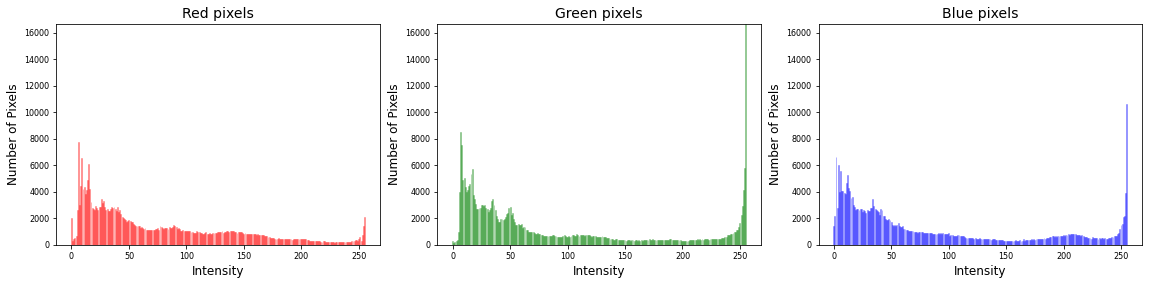

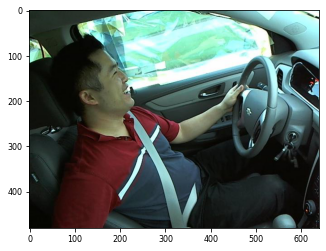

Image File:  img_67845.jpg  from:  imgs/train/c9


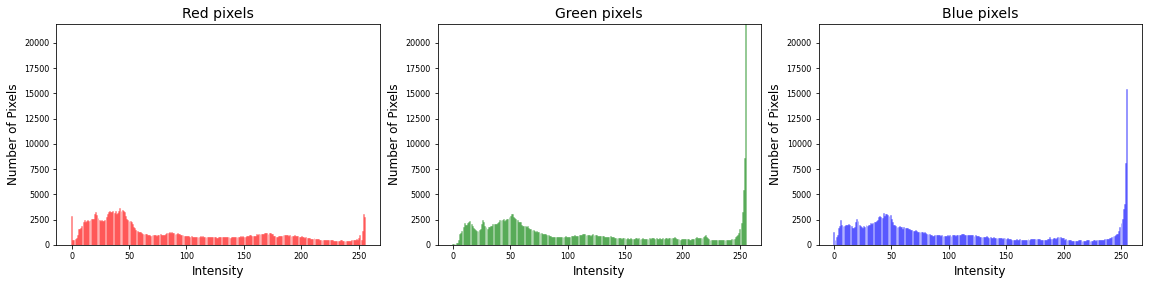

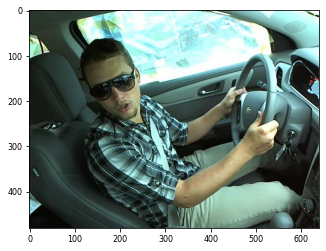

Image File:  img_34827.jpg  from:  imgs/train/c3


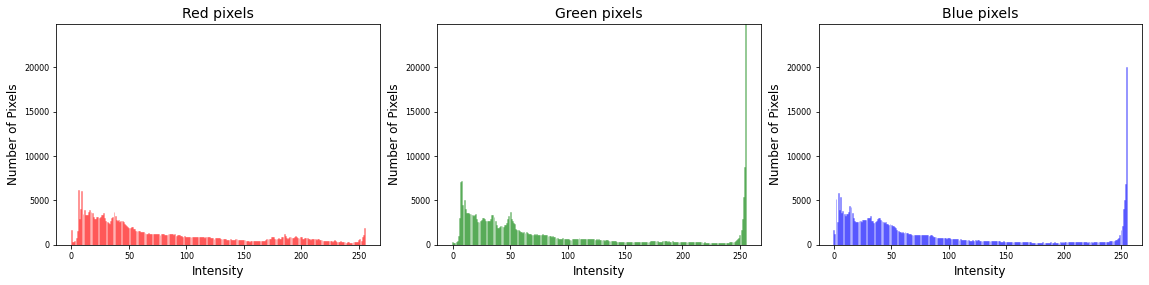

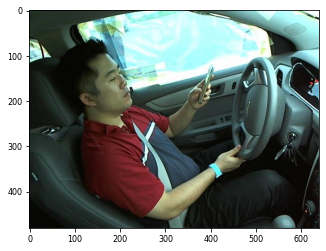

Image File:  img_26781.jpg  from:  imgs/train/c4


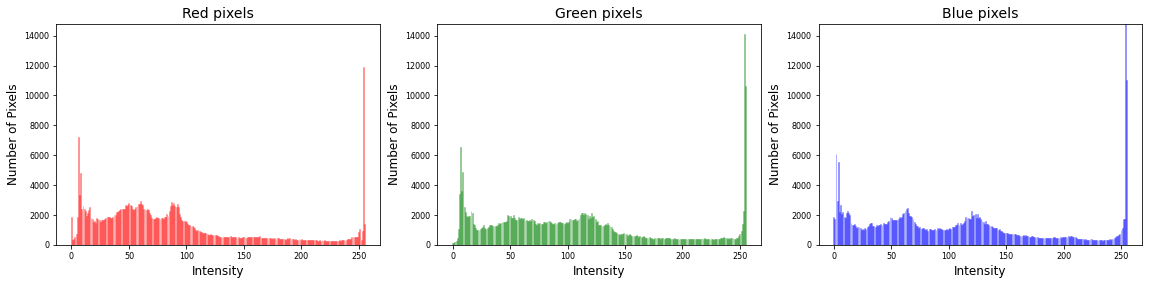

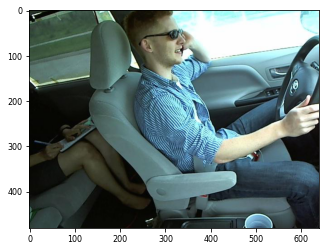

Image File:  img_28711.jpg  from:  imgs/train/c6


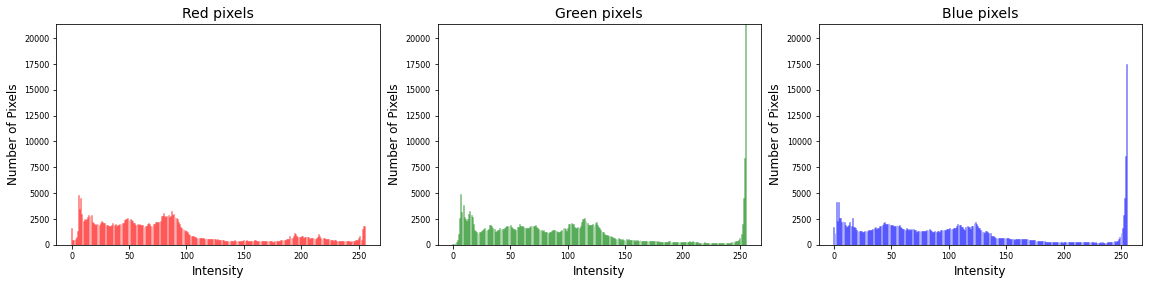

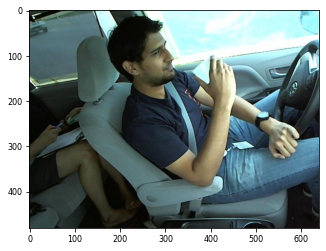

Image File:  img_1567.jpg  from:  imgs/train/c8


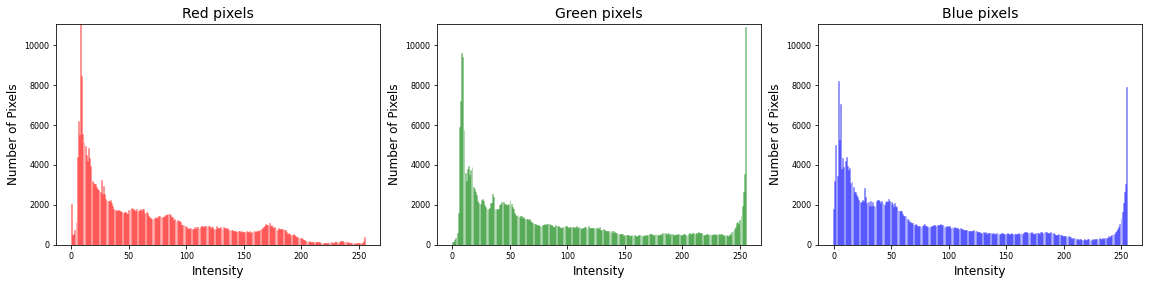

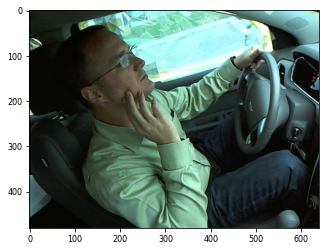

Image File:  img_40038.jpg  from:  imgs/train/c0


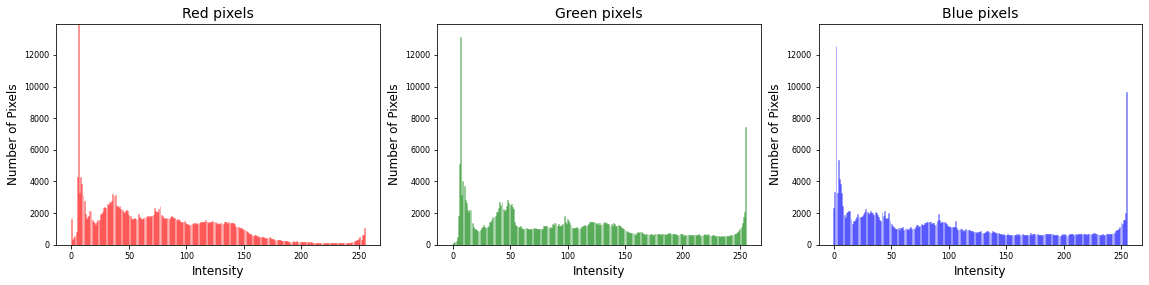

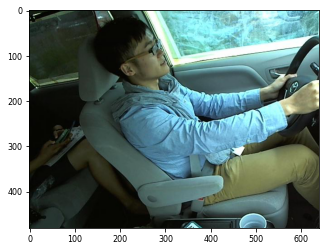

Image File:  img_24547.jpg  from:  imgs/train/c5


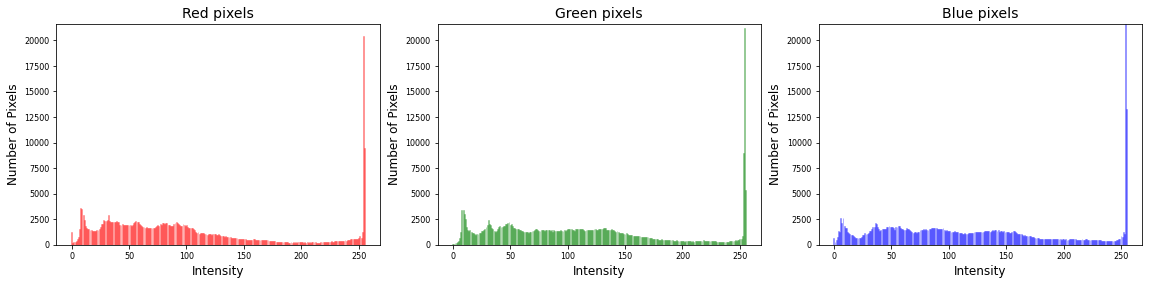

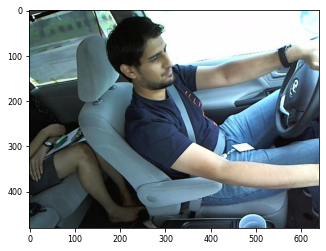

In [0]:
# Sample the first image from each class. Show the image and the pixel intensity distribution. 
imgs = []
imgs_filenames = []


for root, dirs, files in os.walk(raw_train_path):
    if len(files) > 0:
        dir = root.rsplit('\\', 1)
        print("Image File: ", files[0], " from: ", dir[-1])
        filename = os.path.normpath(os.path.join(root, files[0]))
        imgs_filenames.append(filename)
        rgb_hist_img(filename)
        try:
            img = Image.open(filename)
        except IOError:
            img = ""
            print("Cannot open image file")
        imgs.append(img)
        plt.imshow(img)
        plt.show()
        

#### Pixel intensity distribution really depends on driver's clothes, how much of car is showing, and what is seen through window. There seems to be a lot of extraneous data in the image.  

#### Crop the images and try to focus in on just the driver. 

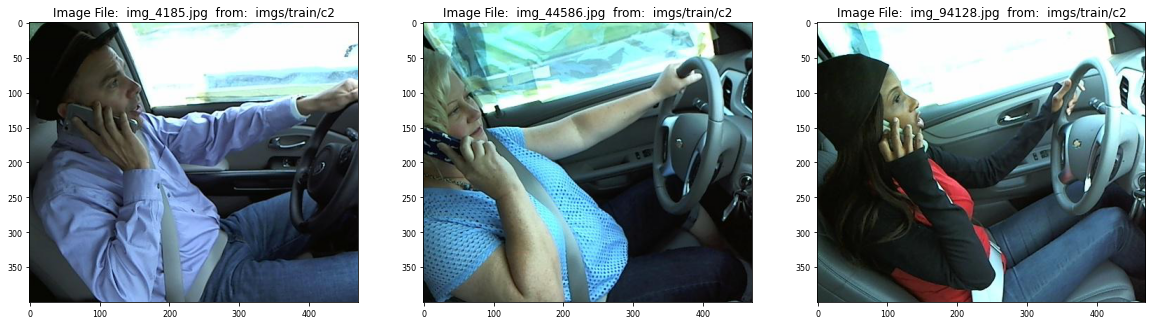

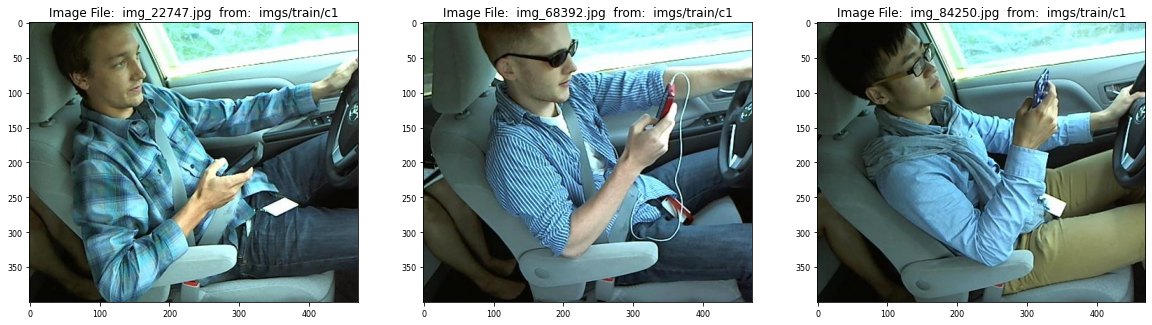

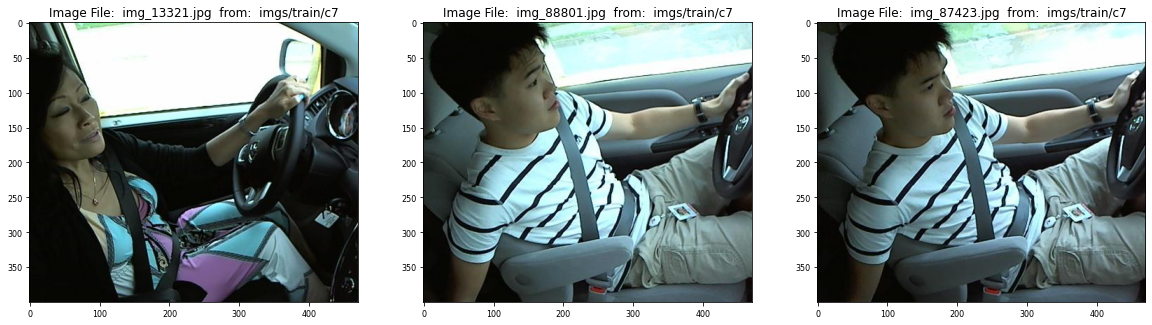

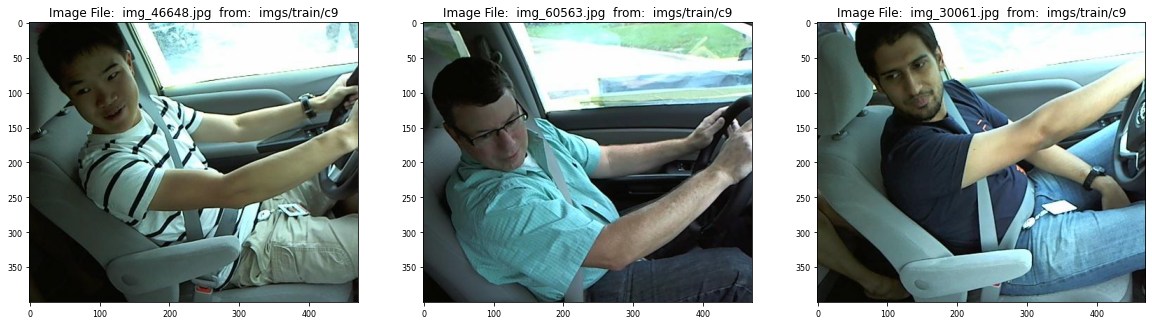

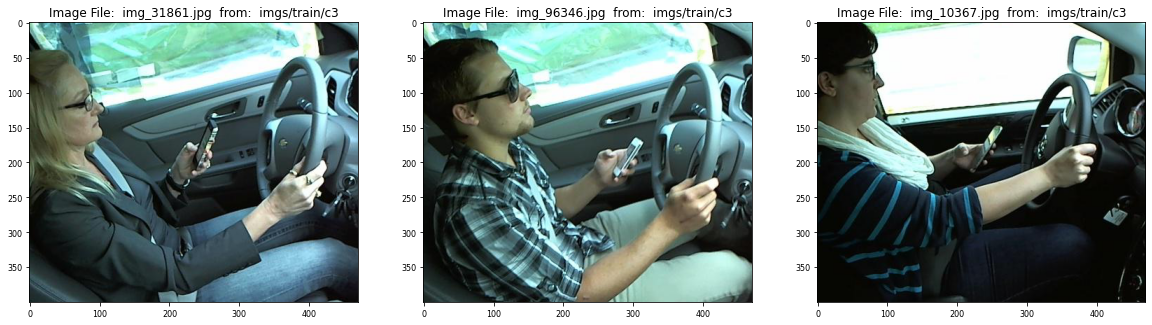

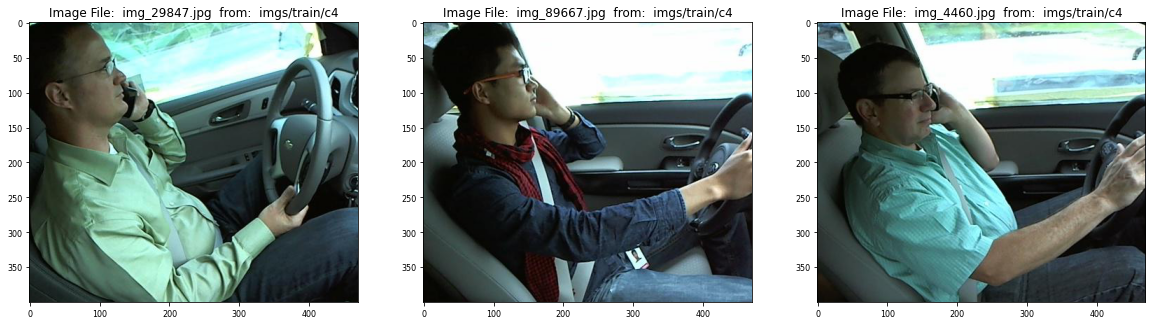

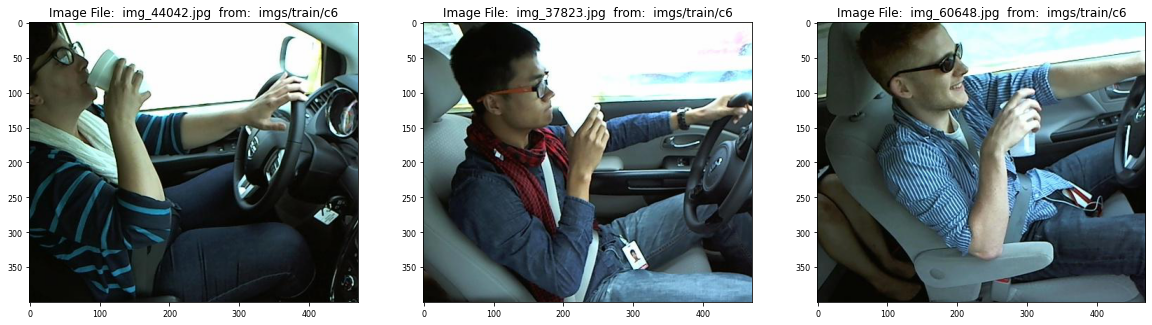

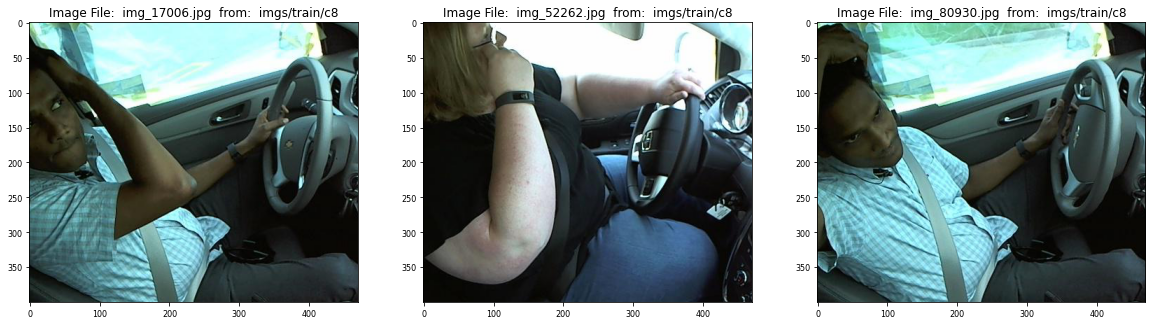

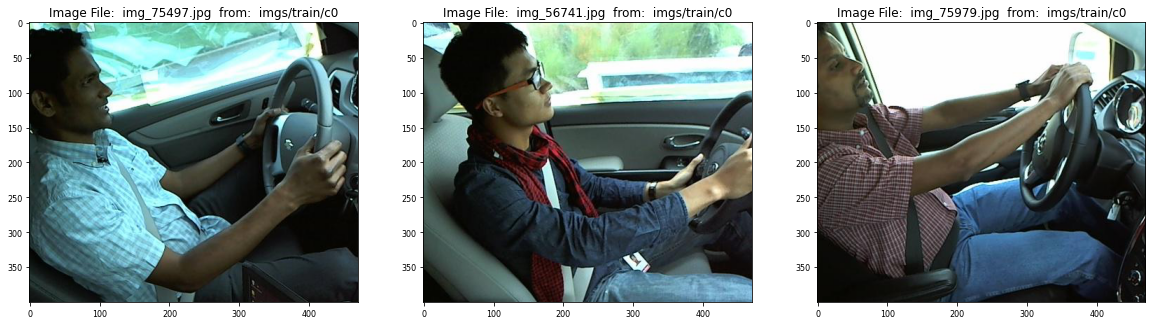

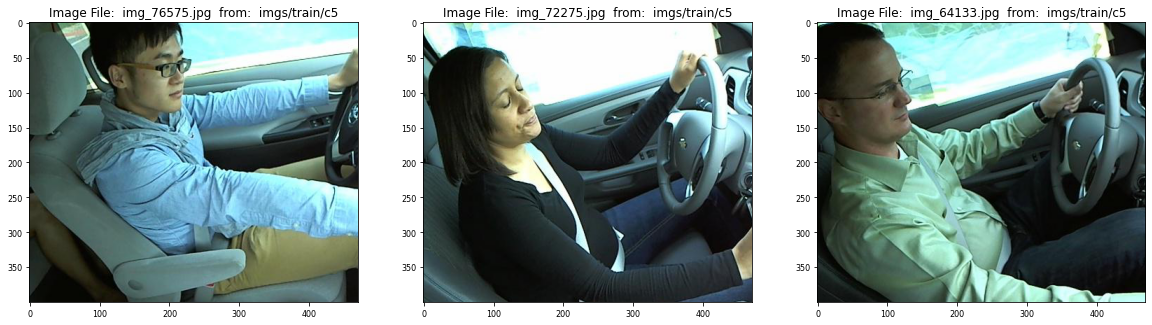

In [0]:
# Sample the first three images from each class. Show the cropped images. 


for root, dirs, files in os.walk(raw_train_path):
    if len(files) > 0:
        dir = root.rsplit('\\', 1)
        plt.figure(figsize=(20, 10))
        for i in range(3):
            j = i + 10
            plt.subplot(1, 3, i+1)
            title = " ".join(["Image File: ", files[j], " from: ", dir[-1]])
            filename = os.path.normpath(os.path.join(root, files[j]))
            try:
                img = Image.open(filename)
            except IOError:
                img = ""
                print("Cannot open image file")
            img = np.array(img)
            img = img[40:440, 120:590, :]
            plt.imshow(img)
            plt.title(title, fontsize=MEDIUM_SIZE)
        plt.show()

### Let's try modeling with this. It seems to be a compromise in leaving some junk but not cutting off important data. 

### Create train-test split, keeping each subject's images entirely in train, validate or test to avoid leaking into test. There are only 26 drivers in the 22,424 images. We want to make sure we know how our models will respond to new drivers, so make sure no test or validation drivers are in the training set.  

Create pivot table of image distribution by driver, split on driver id. 

In [0]:
# How are drivers distributed across classes? 
driver_images_list.groupby(['subject', 'classname']).count()

img
subject classname     
p002    c0          76
        c1          74
        c2          86
        c3          79
        c4          84
...                ...
p081    c5          81
        c6          79
        c7          77
        c8          61
        c9          80

[260 rows x 1 columns]

In [0]:
driver_classes = pd.pivot_table(driver_images_list, values='img', index=['subject'], columns=['classname'], aggfunc=len)
driver_classes

classname   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
subject                                                    
p002        76   74   86   79   84   76   83   72   44   51
p012        84   95   91   89   97   96   75   72   62   62
p014       100  103  100  100  103  102  101   77   38   52
p015        79   85   88   94  101  101   99   81   86   61
p016       111  102  101  128  104  104  108  101   99  120
p021       135  131  127  128  132  130  126   98   99  131
p022       129  129  128  129  130  130  131   98   98  131
p024       130  129  128  130  129  131  129  101   99  120
p026       130  129  130  131  126  130  128   97   97   98
p035        94   81   88   89   89   89   94   87   56   81
p039        65   63   70   65   62   64   63   64   70   65
p041        60   64   60   60   60   61   61   61   59   59
p042        59   59   60   59   58   59   59   59   59   60
p045        75   75   76   75   75   76   71   67   66   68
p047        80   91   81   86   82   87   81   82   82   83
p049        84   85  119  110  109  116  119   74   79  116
p050       123   45   52   98   83   91   82   81   65   70
p051       182   81   81   83   81   83   95   80   62   92
p052        72   71   84   75   72   72   77   71   71   75
p056        81   80   80   78   82   81   80   74   83   75
p061        84   81   81   83   79   81   80   79   81   80
p064        83   81   83   84   86   85   82   79   81   76
p066       129  100  106  101  102  101  105   86  114   90
p072        63   62   36   31   34    6   35    2   21   56
p075        81   81   85   79   89   79   82   82   79   77
p081       100   90   96   82   77   81   79   77   61   80

In [0]:
driver_images_total = pd.DataFrame()
driver_images_total['all_classes'] = driver_classes.sum(axis=1)
driver_images_total['pct_of_train'] = driver_images_total['all_classes'] * 100 / NUM_TRAIN_IMGS
driver_images_total

all_classes  pct_of_train
subject                           
p002             725      3.233143
p012             823      3.670175
p014             876      3.906529
p015             875      3.902069
p016            1078      4.807349
p021            1237      5.516411
p022            1233      5.498573
p024            1226      5.467356
p026            1196      5.333571
p035             848      3.781663
p039             651      2.903139
p041             605      2.698002
p042             591      2.635569
p045             724      3.228684
p047             835      3.723689
p049            1011      4.508562
p050             790      3.523011
p051             920      4.102747
p052             740      3.300036
p056             794      3.540849
p061             809      3.607742
p064             820      3.656796
p066            1034      4.611131
p072             346      1.542990
p075             814      3.630039
p081             823      3.670175

In [0]:
print("Total number of images: ", NUM_TRAIN_IMGS)
print("\nPercentage of images per class:")
driver_classes.sum()*100/NUM_TRAIN_IMGS

Total number of images:  22424

Percentage of images per class:


classname
c0    11.099715
c1    10.109704
c2    10.332679
c3    10.462005
c4    10.372815
c5    10.310382
c6    10.368355
c7     8.927934
c8     8.522119
c9     9.494292
dtype: float64

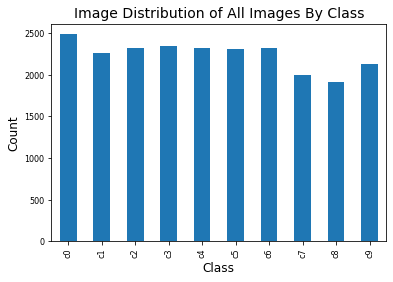

In [0]:
driver_classes.sum().plot(kind='bar')
plt.title('Image Distribution of All Images By Class', fontsize=BIGGER_SIZE)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

### First, split test images from train by driver.  
#### Had to play with test_size as can't get desired 20% exactly due to splitting on driver id. 

In [0]:
X_train, X_test = train_test_split(driver_classes, test_size=0.18, random_state=42)

In [0]:
# Which drivers are in test set?
X_test

classname   c0   c1   c2   c3   c4   c5   c6  c7  c8  c9
subject                                                 
p026       130  129  130  131  126  130  128  97  97  98
p050       123   45   52   98   83   91   82  81  65  70
p002        76   74   86   79   84   76   83  72  44  51
p075        81   81   85   79   89   79   82  82  79  77
p041        60   64   60   60   60   61   61  61  59  59

In [0]:
# How many total images in test set and what percentage of total number of images?
X_test.sum().sum(), X_test.sum().sum()*100/NUM_TRAIN_IMGS

(4130, 18.41776667855869)

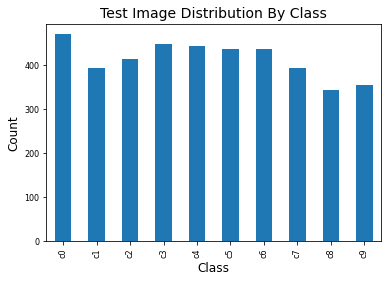

In [0]:
# Distribution of images in test set. 
X_test.sum().plot(kind='bar')
plt.title('Test Image Distribution By Class', fontsize=BIGGER_SIZE)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [0]:
# Which drivers are left in train?
X_train

classname   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
subject                                                    
p035        94   81   88   89   89   89   94   87   56   81
p045        75   75   76   75   75   76   71   67   66   68
p012        84   95   91   89   97   96   75   72   62   62
p072        63   62   36   31   34    6   35    2   21   56
p021       135  131  127  128  132  130  126   98   99  131
p014       100  103  100  100  103  102  101   77   38   52
p042        59   59   60   59   58   59   59   59   59   60
p049        84   85  119  110  109  116  119   74   79  116
p015        79   85   88   94  101  101   99   81   86   61
p016       111  102  101  128  104  104  108  101   99  120
p064        83   81   83   84   86   85   82   79   81   76
p051       182   81   81   83   81   83   95   80   62   92
p066       129  100  106  101  102  101  105   86  114   90
p052        72   71   84   75   72   72   77   71   71   75
p081       100   90   96   82   77   81   79   77   61   80
p061        84   81   81   83   79   81   80   79   81   80
p024       130  129  128  130  129  131  129  101   99  120
p039        65   63   70   65   62   64   63   64   70   65
p047        80   91   81   86   82   87   81   82   82   83
p056        81   80   80   78   82   81   80   74   83   75
p022       129  129  128  129  130  130  131   98   98  131

In [0]:
# What is total number of images left in train and percentage of total number of images?
X_train.sum().sum(), X_train.sum().sum()*100/NUM_TRAIN_IMGS

(18294, 81.58223332144131)

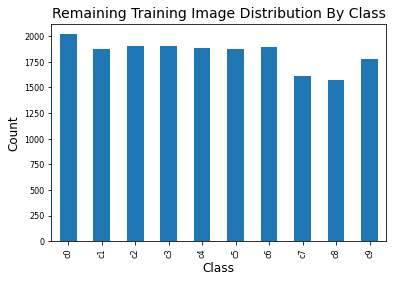

In [0]:
X_train.sum().plot(kind='bar')
plt.title('Remaining Training Image Distribution By Class', fontsize=BIGGER_SIZE)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

#### Now split the validation set from the remaining training image set. 

In [0]:
X_train, X_valid = train_test_split(X_train, test_size=0.2, random_state=42)

In [0]:
# Which drivers are left in the training set?
X_train

classname   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
subject                                                    
p014       100  103  100  100  103  102  101   77   38   52
p051       182   81   81   83   81   83   95   80   62   92
p072        63   62   36   31   34    6   35    2   21   56
p047        80   91   81   86   82   87   81   82   82   83
p024       130  129  128  130  129  131  129  101   99  120
p052        72   71   84   75   72   72   77   71   71   75
p012        84   95   91   89   97   96   75   72   62   62
p016       111  102  101  128  104  104  108  101   99  120
p022       129  129  128  129  130  130  131   98   98  131
p021       135  131  127  128  132  130  126   98   99  131
p066       129  100  106  101  102  101  105   86  114   90
p049        84   85  119  110  109  116  119   74   79  116
p064        83   81   83   84   86   85   82   79   81   76
p081       100   90   96   82   77   81   79   77   61   80
p056        81   80   80   78   82   81   80   74   83   75
p042        59   59   60   59   58   59   59   59   59   60

In [0]:
# What is total number of images left in train and percentage of total number of images?
X_train.sum().sum(), X_train.sum().sum()*100/NUM_TRAIN_IMGS

(14387, 64.15893685337139)

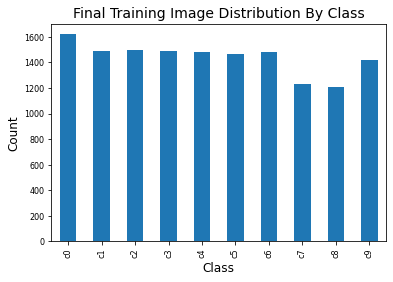

In [0]:
X_train.sum().plot(kind='bar')
plt.title('Final Training Image Distribution By Class', fontsize=BIGGER_SIZE)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [0]:
# Which drivers are in the validation set?
X_valid

classname  c0  c1  c2  c3   c4   c5  c6  c7  c8  c9
subject                                            
p035       94  81  88  89   89   89  94  87  56  81
p039       65  63  70  65   62   64  63  64  70  65
p061       84  81  81  83   79   81  80  79  81  80
p045       75  75  76  75   75   76  71  67  66  68
p015       79  85  88  94  101  101  99  81  86  61

In [0]:
# What is total number of images in the validation set and the percentage of total number of images?
X_valid.sum().sum(), X_valid.sum().sum()*100/NUM_TRAIN_IMGS

(3907, 17.423296468069925)

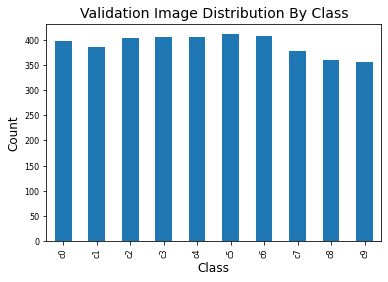

In [0]:
X_valid.sum().plot(kind='bar')
plt.title('Validation Image Distribution By Class', fontsize=BIGGER_SIZE)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [0]:
def create_model_data_structure(top_level_path):
    """
    Create directory structure for model data as shutil.copy2() will not create directories on copy on Colab (although it did on Windows computer).  

    Input:     top_level_path: top level directory under which to build subdirectory for each class name. 
    """

    import os

    try:
        os.makedirs(top_level_path, exist_ok=True)
    except OSError as err:
        print(err)
        return()
    for i in range(0,10):
       subdir = os.path.join(top_level_path, "c"+str(i))
       try:
           os.makedirs(subdir, exist_ok=True)
       except OSError as err:
           print(err)
           return()
    return()

create_model_data_structure(proc_train_path)
create_model_data_structure(proc_test_path)
create_model_data_structure(proc_valid_path)


()

### Set up data structure for modeling.  
#### Original data with labeled train and unlabeled test is in raw_data_path. Ignore unlabeled test data as we cannot evaluate a model's performance on new data without labels. Instead, split labeled training data in raw_data_path into train, valid and test and copy it into the proc_data_path. 
#### Copy raw_train_path X_train subject images to proc_train_path subdirectories corresponding to labeled class. 
#### Copy raw_train_path X_test subject images to proc_test_path subdirectories corresponding to labeled class. 
#### Copy raw_train_path X_valid subject images to proc_valid_path subdirectories corresponding to labeled class. 

In [0]:
def copy_model_data(subset, drivers, src_path, dest_path):
    """
    Copy subset of data from src_path to dest_path for modeling due to splitting
        labeled training data into train/validate/test. 
    
    Inputs:    
            subset:      subset of drivers to copy from driver_classes train_test_split()
            drivers:     complete list of drivers (default: driver_images_list)
            src_path:    source path of copy (default: raw_train_path)
            dest_path:   destination path of copy (train/valid/test)

    Return: error status
    """
    import shutil
    
    copy_error = False
  
    
    for subject in subset.index.values:
        logging.debug("new subject: {}".format(subject))
        for classes in drivers[drivers['subject'] == subject]['classname'].unique():
            logging.debug("new class: {}".format(classes))
            for image_files in drivers[(drivers['subject'] == subject) & \
                                                  (drivers['classname'] == classes)]['img'].values:
                logging.debug("new file: {}".format(image_files))
                src_image_file = os.path.normpath(os.path.join(src_path, classes, image_files))
                dst_image_dir = os.path.normpath(os.path.join(dest_path, classes))
                try:
                    logging.debug("new copy: {}, {}".format(src_image_file, dst_image_dir))
                    shutil.copy2(src_image_file, dst_image_dir)
                except IOError:
                    logging.warning("copy failed: {}, {}".format(src_image_file, dst_image_dir))
                    copy_error = True


    return(copy_error)

def build_model_data():
    """
    Build data structure for modeling from X_train, X_test. 
    
    Returns error status: True (error on copies) or False (no errors)
    """
   
    import sys
    

    copy_error = False
    

# Note: source for all test images is raw_train_path as we are dividing up the labeled training images to create 
#    labeled test and validation sets. 

    copy_model_data(X_train, driver_images_list, raw_train_path, proc_train_path)
  
    copy_model_data(X_test, driver_images_list, raw_train_path, proc_test_path)
    
    copy_model_data(X_valid, driver_images_list, raw_train_path, proc_valid_path)
    
    return(copy_error)

import logging
logging.basicConfig(filename="build_model.log", level=logging.WARNING)
#status = build_model_data()
#print("Error status: ", status)

In [0]:
def crop_and_copy_data(subset, drivers, src_path, dest_path):
    """
    Copy subset of data from src_path to dest_path for modeling due to splitting
        labeled training data into train/validate/test. 
    
    Inputs:    
            subset:      subset of drivers to copy from driver_classes train_test_split()
            drivers:     complete list of drivers (default: driver_images_list)
            src_path:    source path of copy (default: raw_train_path)
            dest_path:   destination path of copy (train/valid/test)

    Return: error status
    """
    
    copy_error = False 
    crop_box = (120, 40, 590, 440)
    
    for subject in subset.index.values:
        logging.debug("new subject: {}".format(subject))
        for class_ in drivers[drivers['subject'] == subject]['classname'].unique():
            logging.debug("new class: {}".format(class_))
            for image_file in drivers[(drivers['subject'] == subject) & \
                                                  (drivers['classname'] == class_)]['img'].values:
                logging.debug("new file: {}".format(image_file))
                src_image_file = os.path.normpath(os.path.join(src_path, class_, image_file))
                dst_image_file = os.path.normpath(os.path.join(dest_path, class_, image_file))
                try:
                    logging.debug("new open: {}".format(src_image_file))
                    img = Image.open(src_image_file)
                except IOError:
                    logging.warning("open failed: {}".format(src_image_file))
                    copy_error = True
                    return(copy_error)
                img = img.crop(crop_box)
                try:
                    logging.debug("new save: {}".format(dst_image_file))
                    img.save(dst_image_file)
                except IOError:
                    logging.warning("save failed: {}".format(dst_image_file))
                    copy_error = True
                    return(copy_error)
                              
    return(copy_error)

def build_model_data():
    """
    Build data structure for modeling from X_train, X_test. 
    
    Returns error status: True (error on copies) or False (no errors)
    """
    copy_error = False
    
# Note: source for all test images is raw_train_path as we are dividing up the labeled training images to create 
#    labeled test and validation sets. 

    crop_and_copy_data(X_train, driver_images_list, raw_train_path, proc_train_path)
  
    crop_and_copy_data(X_test, driver_images_list, raw_train_path, proc_test_path)
    
    crop_and_copy_data(X_valid, driver_images_list, raw_train_path, proc_valid_path)
    
    return(copy_error)

import logging
logging.basicConfig(filename="build_model.log", level=logging.WARNING)
status = build_model_data()
print("Error status: ", status)

Error status:  False


Verify we have the correct split. 

In [0]:
# Find total number of training images
num_train_imgs = 0
for root, dirs, files in os.walk(proc_train_path):
    num_train_imgs += len(files)
num_train_imgs, num_train_imgs/NUM_TRAIN_IMGS

(14387, 0.6415893685337138)

In [0]:
# Find total number of test images
num_test_imgs = 0
for root, dirs, files in os.walk(proc_test_path):
    num_test_imgs += len(files)
num_test_imgs, num_test_imgs/NUM_TRAIN_IMGS

(4130, 0.18417766678558686)

In [0]:
# Find total number of validation images
num_valid_imgs = 0
for root, dirs, files in os.walk(proc_valid_path):
    num_valid_imgs += len(files)
num_valid_imgs, num_valid_imgs/NUM_TRAIN_IMGS

(3907, 0.17423296468069924)

## Save model data structure in a zip file and copy to Google Drive for storage. 
#### Code adapted from https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory-in-python. 

In [0]:
import os
import zipfile

def zipdir(path, ziph):
    """
    Zip a directory tree starting at path. 

    Input:    path: top level directory to zip
    ziph:     ZipFile object
    """
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('processed.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('proc/', zipf)
zipf.close()

In [0]:
!cp processed.zip "{project_path}"